In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import os
from PIL import Image, ImageFont, ImageDraw

from src.data.data_converter import tokens_to_weights, weights_to_flattened_weights
from src.core.config import TransformerExperimentConfig, DataConfig, DataSelector, DatasetType
from src.models.autoencoder import pl_transformer
from src.data.inr_dataset import INRDataset
from src.data.utils import get_files_from_selectors
from src.data.inr import INR

from src.evaluation import model_utils, metrics, visualization_utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
config = TransformerExperimentConfig.default()

config.model.num_heads = 8
config.model.num_layers = 8

config.model.d_model = 512  # 256 -> 4
config.model.latent_dim = 8
config.model.layer_norm = False

config.data = DataConfig.small()
config.data.selector = DataSelector(dataset_type=DatasetType.MNIST, class_label=2)

In [8]:
# Initialize model
model = pl_transformer.Autoencoder(config)
path = "good checkpoints/best_overfit_so_far_099_split.ckpt"
state_dict = torch.load(path)
model.load_state_dict(state_dict["state_dict"])

# Initialize dataset
data_path = os.path.join(os.getcwd(), config.data.data_path)
files = get_files_from_selectors(data_path, [config.data.selector])
dataset = INRDataset(files, "cpu", False)

print(len(dataset))

# Initialize INR
mlp = INR(up_scale=16)

C:\Users\simon\AppData\Local\Temp\ipykernel_5384\178405932.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


6990


### Take n random samples from the dataset and calculate the original and the reconstructed image and the respective MSEs

In [10]:
n_samples = 50

images, recons, mse_weights, mse_images = model_utils.get_n_images_and_mses(vae=model, dataset=dataset, inr=mlp, n_samples=n_samples)

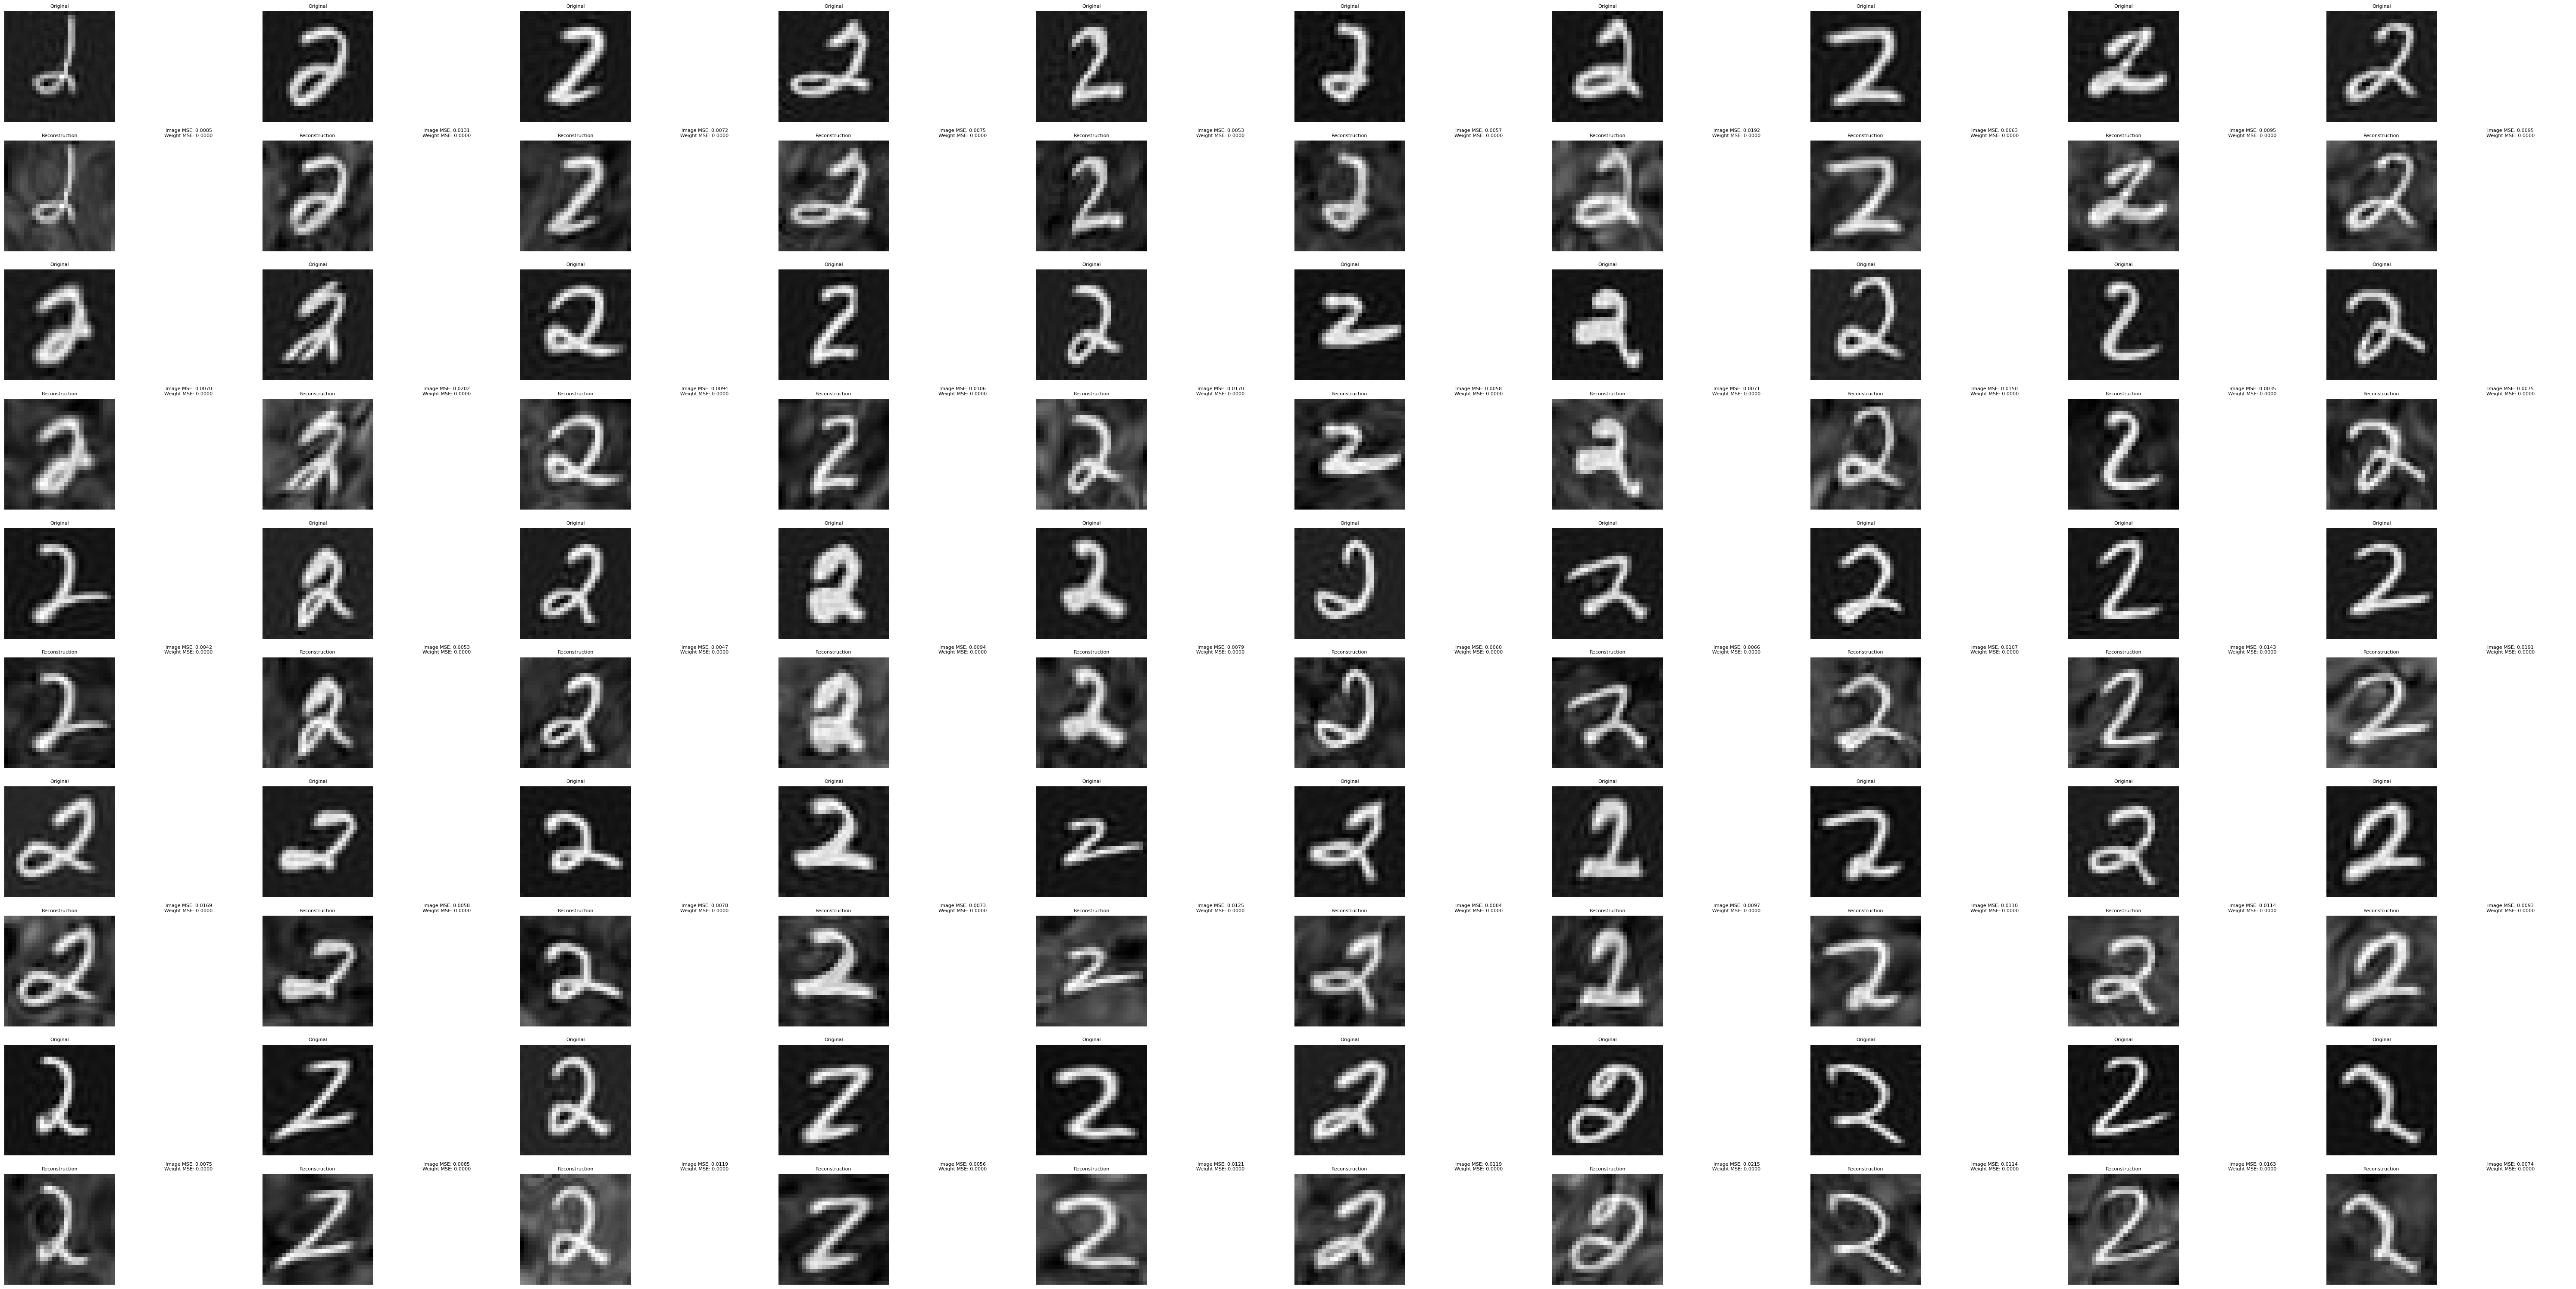

In [11]:
visualization_utils.plot_n_images_and_reconstructions(images=images, reconstructions=recons, mse_weights=mse_weights, mse_images=mse_images)

### Generate images by sampling in the latent space

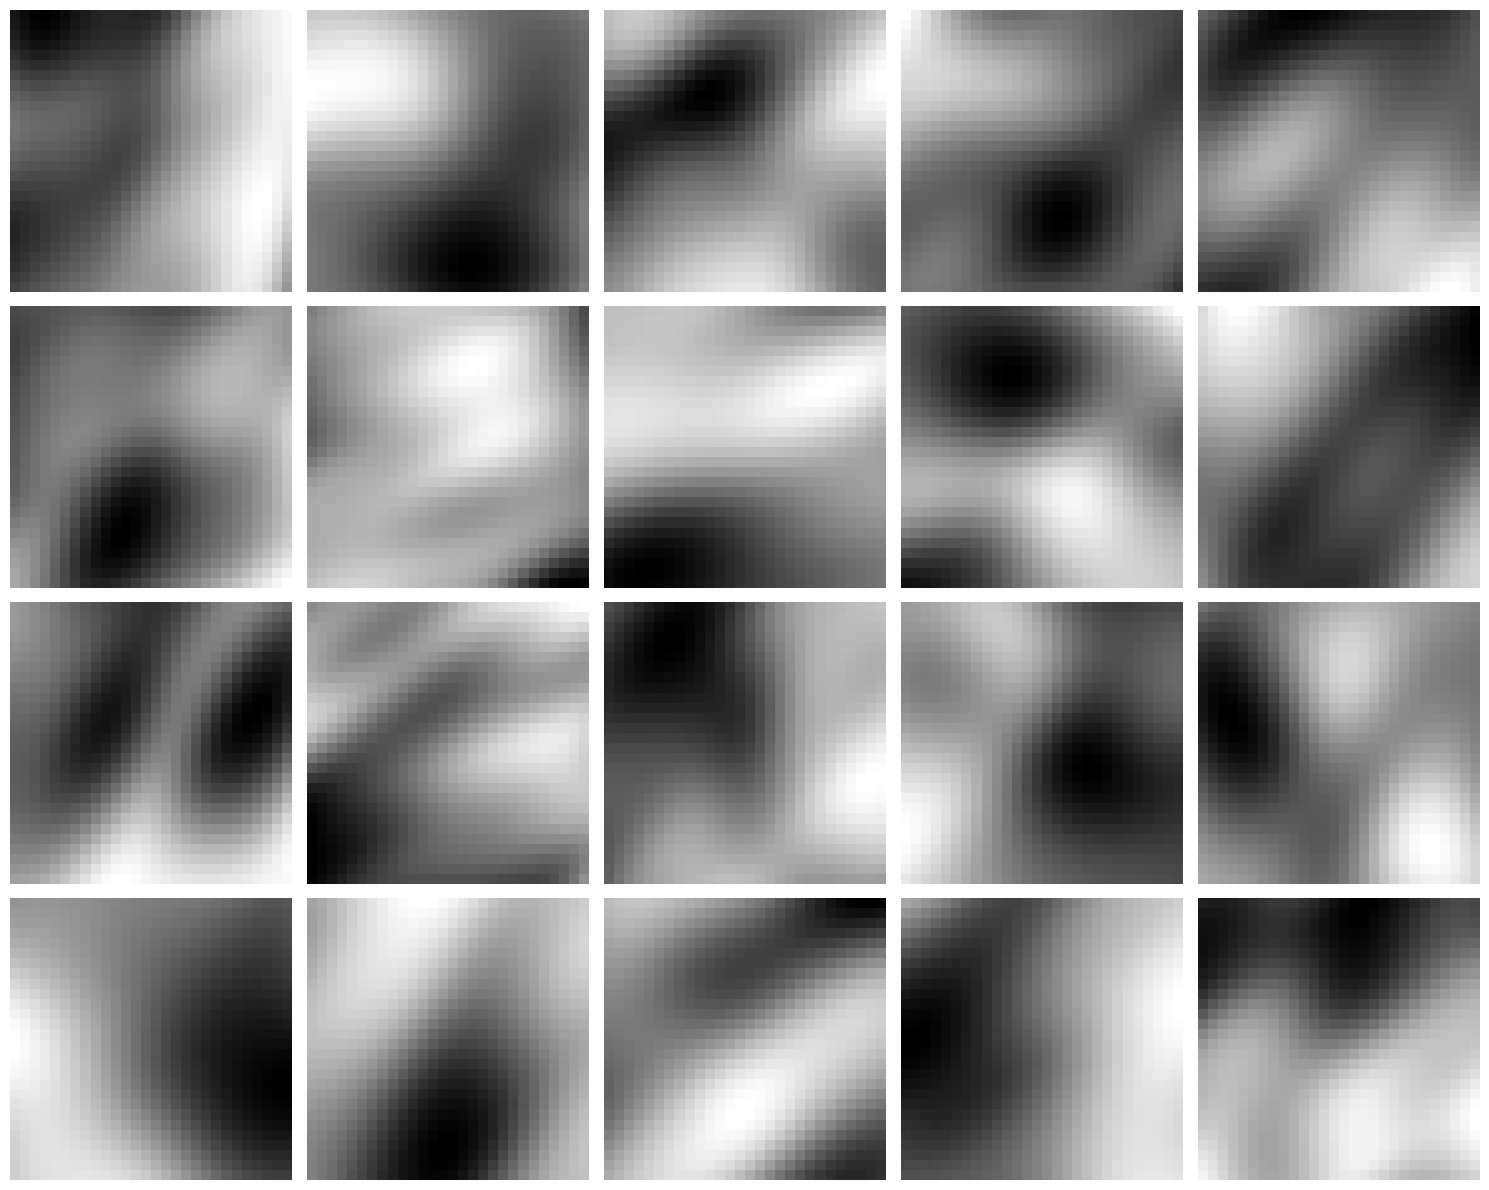

In [13]:
num_samples = 20
images = model_utils.sample_from_latent_space(vae=model, inr=mlp, ref_cp=dataset.get_state_dict(0), pos=dataset[0][2], 
                                              n_tokens=config.model.n_tokens, latent_dim=config.model.latent_dim, n_samples=num_samples)

visualization_utils.plot_n_images(images=images, row=False)

### Get best images/reconstructions in batch

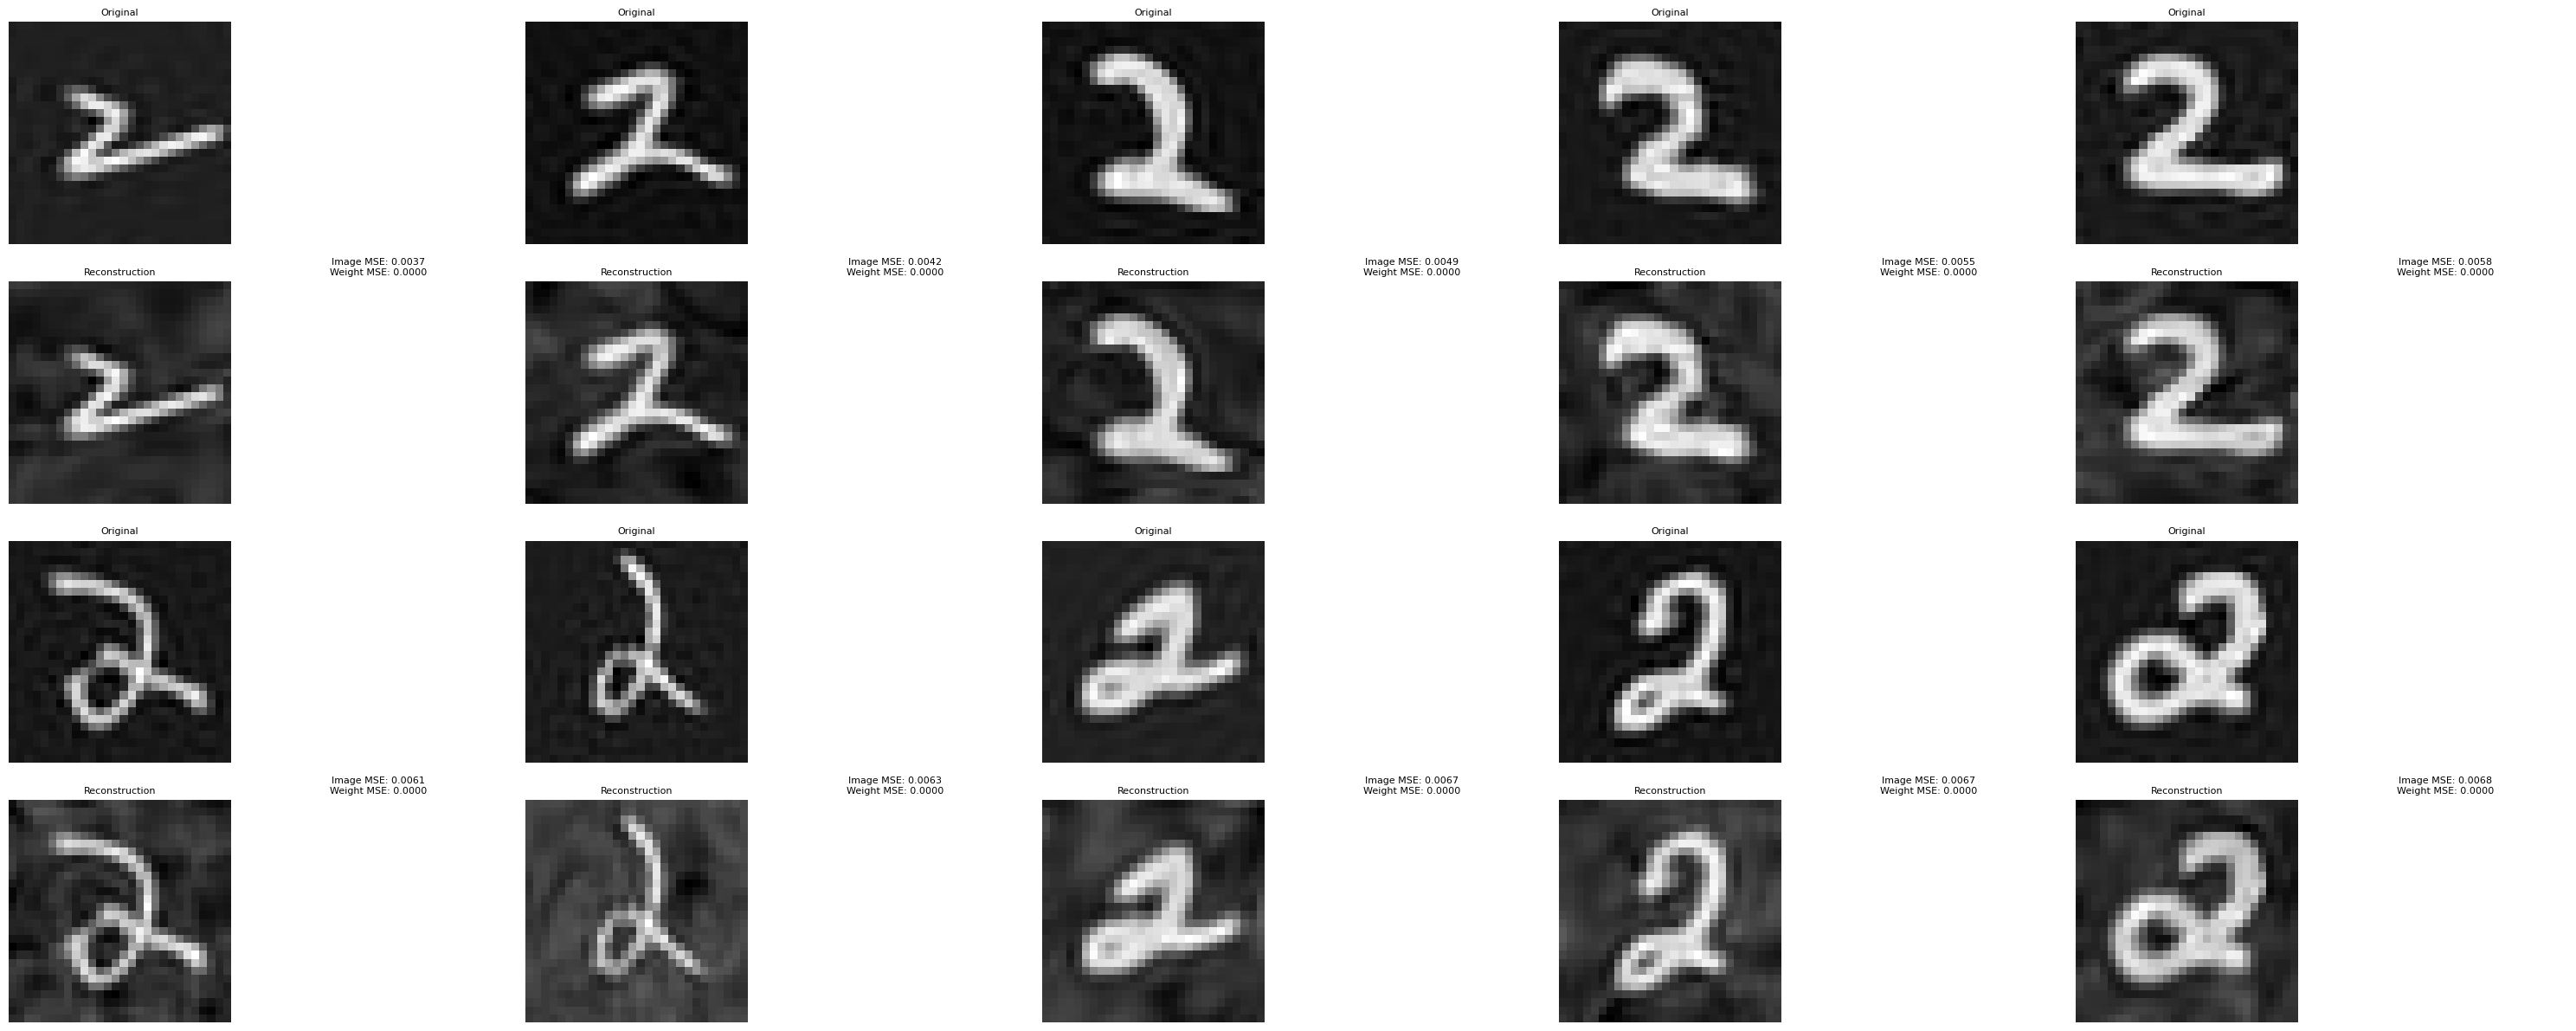

In [14]:
images, reconstructions, mse_weights, image_mses = model_utils.get_n_images_and_mses(model, dataset,mlp, n_samples=n_samples)
result = model_utils.get_best_samples(images, reconstructions, mse_weights, image_mses, best_n=10, sort_by="image")

images, reconstructions, mse_weights, image_mses = zip(*result)

visualization_utils.plot_n_images_and_reconstructions(images, reconstructions, mse_weights, image_mses)

In [15]:
evaluation_path = "evaluation"
output_file_name = "test.png"

path = os.path.join(evaluation_path, output_file_name)

n_samples = 20

images, reconstructions, mse_weights, image_mses = model_utils.get_n_images_and_mses(model, dataset,mlp, n_samples=n_samples)
visualization_utils.render_n_images_and_reconstructions(images=immages, reconstructions=reconstructions, mse_weights=mse_weights, mse_images=image_mses, path=path))

TypeError: render_n_images_and_reconstructions() missing 5 required positional arguments: 'images', 'reconstructions', 'mse_weights', 'mse_images', and 'path'